In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('C:/Users/shail/Desktop/standarddataset/Electric_Production.csv')
df['DATE']= pd.to_datetime(df['DATE'])
df.set_index('DATE', inplace=True)
#df.index.freq='MS'

In [3]:
df = df[-49:-1]
df.head()

,PRODUCTION
DATE,
2014-01-01,124.2549
2014-02-01,112.8811
2014-03-01,104.7631
2014-04-01,90.2867
2014-05-01,92.1340


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2014-01-01 to 2017-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   PRODUCTION  48 non-null     float64
dtypes: float64(1)
memory usage: 768.0 bytes


<AxesSubplot:xlabel='DATE'>

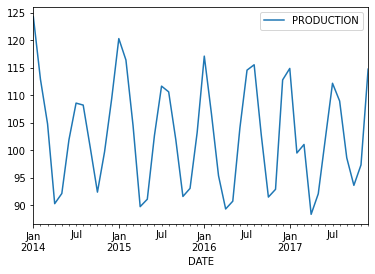

In [6]:
df.plot()

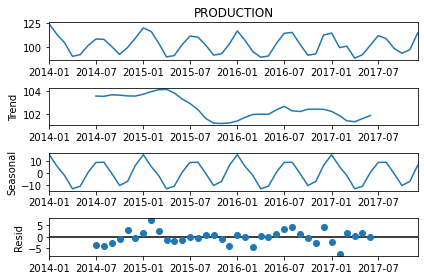

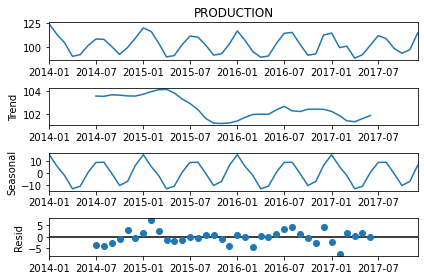

In [7]:
results = seasonal_decompose(df['PRODUCTION'], freq=12)
results.plot()

In [8]:
len(df)

48

In [9]:
train = df.iloc[:36]
test = df.iloc[36:]

scaler = MinMaxScaler()

In [10]:
df.head(), df.tail()

(            PRODUCTION
 DATE                  
 2014-01-01    124.2549
 2014-02-01    112.8811
 2014-03-01    104.7631
 2014-04-01     90.2867
 2014-05-01     92.1340,
             PRODUCTION
 DATE                  
 2017-08-01    108.9312
 2017-09-01     98.6154
 2017-10-01     93.6137
 2017-11-01     97.3359
 2017-12-01    114.7212)

In [11]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

scaled_train[:10]

array([[1.        ],
       [0.67437839],
       [0.44196739],
       [0.02752115],
       [0.08040768],
       [0.35936959],
       [0.55037433],
       [0.54019096],
       [0.3175482 ],
       [0.08755636]])

# Recursive Strategy

In [12]:
n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train,length=n_input,batch_size=1)

generator[0]

(array([[[1.        ],
         [0.67437839],
         [0.44196739],
         [0.02752115],
         [0.08040768],
         [0.35936959],
         [0.55037433],
         [0.54019096],
         [0.3175482 ],
         [0.08755636],
         [0.29710989],
         [0.57322034]]]),
 array([[0.88590446]]))

In [13]:
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               161600    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.fit(generator, epochs=50, verbose=0)

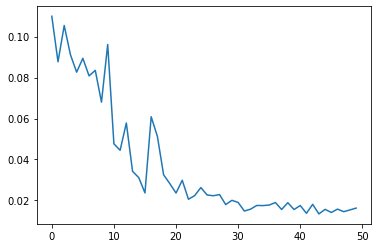

In [15]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [16]:
last_train_batch = scaled_train[-n_input:]

last_train_batch = last_train_batch.reshape((1,n_input, n_features))

model.predict(last_train_batch)

array([[0.71449167]], dtype=float32)

In [17]:
scaled_test[0], scaled_test[1]

(array([0.73076053]), array([0.29100617]))

In [18]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    
    test_predictions.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)
    
test_predictions

[array([0.71449167], dtype=float32),
 array([0.5232331], dtype=float32),
 array([0.2242032], dtype=float32),
 array([0.06031048], dtype=float32),
 array([0.07507002], dtype=float32),
 array([0.48502973], dtype=float32),
 array([0.68574613], dtype=float32),
 array([0.6851579], dtype=float32),
 array([0.4252703], dtype=float32),
 array([0.08346055], dtype=float32),
 array([0.37102774], dtype=float32),
 array([0.64571756], dtype=float32)]

In [19]:
test.head()

,PRODUCTION
DATE,
2017-01-01,114.8505
2017-02-01,99.4901
2017-03-01,101.0396
2017-04-01,88.3530
2017-05-01,92.0805


In [20]:
true_predictions = scaler.inverse_transform(test_predictions)

test['recursive_predict'] = true_predictions

<AxesSubplot:xlabel='DATE'>

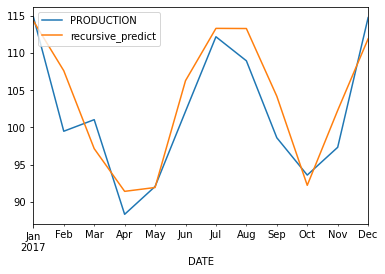

In [21]:
test.plot()

In [22]:
rmse = sqrt(mean_squared_error(test['PRODUCTION'], test['recursive_predict']))
print(rmse)

4.010608792266294


In [23]:
test

,PRODUCTION,recursive_predict
DATE,,
2017-01-01,114.8505,114.282237
2017-02-01,99.4901,107.601671
2017-03-01,101.0396,97.156706
2017-04-01,88.3530,91.432015
2017-05-01,92.0805,91.947558
2017-06-01,102.1532,106.267246
2017-07-01,112.1538,113.278170
2017-08-01,108.9312,113.257623
2017-09-01,98.6154,104.179879


# Direct Startegy

In [24]:
def generate_data(data, n_input, month):
    X, y = [], []
    for i in range(0,len(data)-(n_input+month)):
            X.append(data[i:i+n_input])
            y.append(data[i+n_input+(month-1)])
    return np.array(X), np.array(y)

In [25]:
def model_predict(m_no, train_data, n_input, n_features):
    
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    X, y = generate_data(train_data, n_input, m_no)
    
    #print("MODEL : ", m_no)
    #print(X[0], y[0])
    
    model.fit(X, y, epochs=50, verbose=0)
    
    tX = train_data[-n_input:]
    
    tX = tX.reshape((1, n_input, n_features))
    
    res = model.predict(tX)
    
    return res[0]

In [26]:
n_input = 12
n_features = 1
test_predictions = []

for i in range(len(scaled_test)):
    test_predictions.append(model_predict(i+1,scaled_train,n_input, n_features))
    
test_predictions

[array([0.45596522], dtype=float32),
 array([0.378198], dtype=float32),
 array([0.34455758], dtype=float32),
 array([0.3020378], dtype=float32),
 array([0.32588822], dtype=float32),
 array([0.3537586], dtype=float32),
 array([0.3913307], dtype=float32),
 array([0.38875568], dtype=float32),
 array([0.32428345], dtype=float32),
 array([0.30822366], dtype=float32),
 array([0.3351836], dtype=float32),
 array([0.356736], dtype=float32)]

In [27]:
true_predictions = scaler.inverse_transform(test_predictions)

test['direct_predict'] = true_predictions

<AxesSubplot:xlabel='DATE'>

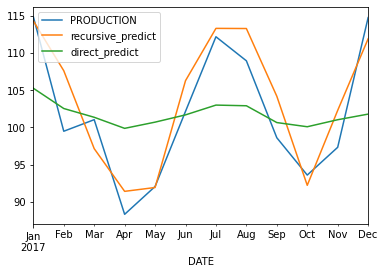

In [28]:
test.plot()

In [29]:
rmse = sqrt(mean_squared_error(test['PRODUCTION'], test['direct_predict']))
print(rmse)

7.395141006374834


In [30]:
test

,PRODUCTION,recursive_predict,direct_predict
DATE,,,
2017-01-01,114.8505,114.282237,105.252037
2017-02-01,99.4901,107.601671,102.535667
2017-03-01,101.0396,97.156706,101.360624
2017-04-01,88.3530,91.432015,99.875430
2017-05-01,92.0805,91.947558,100.708512
2017-06-01,102.1532,106.267246,101.682011
2017-07-01,112.1538,113.278170,102.994385
2017-08-01,108.9312,113.257623,102.904441
2017-09-01,98.6154,104.179879,100.652459


# Direct Recursive Startegy

In [31]:
def generate_data(data, n_input, month):
    X, y = [], []
    for i in range(0,len(data)-(n_input+month)):
            X.append(data[i:i+n_input+(month-1)])
            y.append(data[i+n_input+(month-1)])
    return np.array(X), np.array(y)

In [32]:
def model_predict(m_no, train_data, n_input, n_features):
    
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_input+(m_no - 1), n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    X, y = generate_data(train_data, n_input, m_no)
    #print(y.dtype)
    
    #print("Model No.  - ", m_no)
    #print(X[0], y[0])
    #print("SHAPE XY : ", X.shape, y.shape)
    
    model.fit(X, y, epochs=50, verbose=0)
    
    tX = train_data[-n_input:]
    tP = np.array(test_predictions)
    
    tX = np.concatenate((tX, tP), axis=None)
    
    #print("TYPE : ", type(tX), type(tP))
    
    #print("TX : ", tX)
        
    #print("SHAPE : " , tX.shape)
    
    tX = tX.reshape((1, tX.shape[0], n_features))
    
    res = model.predict(tX)
    
    return res[0]

In [33]:
n_input = 12
n_features = 1
test_predictions = []

for i in range(len(scaled_test)):
    pred = model_predict(i+1,scaled_train,n_input, n_features)
    test_predictions.append(pred)
    
test_predictions

[array([0.41852134], dtype=float32),
 array([0.39435807], dtype=float32),
 array([0.34534764], dtype=float32),
 array([0.34393847], dtype=float32),
 array([0.33876765], dtype=float32),
 array([0.34240142], dtype=float32),
 array([0.37579808], dtype=float32),
 array([0.34327433], dtype=float32),
 array([0.3145141], dtype=float32),
 array([0.32665536], dtype=float32),
 array([0.3433614], dtype=float32),
 array([0.35034046], dtype=float32)]

In [34]:
true_predictions = scaler.inverse_transform(test_predictions)

test['direct_recursive_predict'] = true_predictions

<AxesSubplot:xlabel='DATE'>

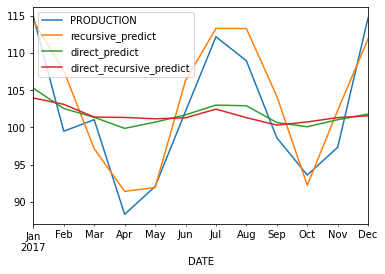

In [35]:
test.plot()

In [36]:
rmse = sqrt(mean_squared_error(test['PRODUCTION'], test['direct_recursive_predict']))
print(rmse)

8.055161417833276


In [37]:
test

,PRODUCTION,recursive_predict,direct_predict,direct_recursive_predict
DATE,,,,
2017-01-01,114.8505,114.282237,105.252037,103.944141
2017-02-01,99.4901,107.601671,102.535667,103.100130
2017-03-01,101.0396,97.156706,101.360624,101.388220
2017-04-01,88.3530,91.432015,99.875430,101.338999
2017-05-01,92.0805,91.947558,100.708512,101.158385
2017-06-01,102.1532,106.267246,101.682011,101.285310
2017-07-01,112.1538,113.278170,102.994385,102.451839
2017-08-01,108.9312,113.257623,102.904441,101.315801
2017-09-01,98.6154,104.179879,100.652459,100.311220


# MIMO

In [38]:
def generate_data(data, n_input, n_output):
    X, y = [], []
    for i in range(0,len(data)-(n_input+n_output)):
            X.append(data[i:(i+n_input)])
            y.append(data[i+n_input: i+n_input+n_output])
    return np.array(X), np.array(y)

In [39]:
n_input = 12
n_features = 1
n_output = len(scaled_test)

X, y = generate_data(scaled_train, n_input, n_output)

In [40]:
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(n_output))
model.compile(optimizer='adam', loss='mse')

In [41]:
model.fit(X, y, epochs=50, verbose=0)

In [42]:
model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 200)               161600    
_________________________________________________________________
dense_25 (Dense)             (None, 12)                2412      
Total params: 164,012
Trainable params: 164,012
Non-trainable params: 0
_________________________________________________________________


In [43]:
tX = scaled_train[-n_input:]
tX = tX.reshape((1, tX.shape[0], n_features))

res = model.predict(tX)

res = res.reshape((res.shape[1],1))

In [44]:
res.shape

(12, 1)

In [45]:
true_predictions = scaler.inverse_transform(res)

test['MIMO_predict'] = true_predictions

In [46]:
test

,PRODUCTION,recursive_predict,direct_predict,direct_recursive_predict,MIMO_predict
DATE,,,,,
2017-01-01,114.8505,114.282237,105.252037,103.944141,103.959137
2017-02-01,99.4901,107.601671,102.535667,103.100130,104.223694
2017-03-01,101.0396,97.156706,101.360624,101.388220,101.974792
2017-04-01,88.3530,91.432015,99.875430,101.338999,100.556419
2017-05-01,92.0805,91.947558,100.708512,101.158385,101.001511
2017-06-01,102.1532,106.267246,101.682011,101.285310,101.101501
2017-07-01,112.1538,113.278170,102.994385,102.451839,101.294472
2017-08-01,108.9312,113.257623,102.904441,101.315801,101.807053
2017-09-01,98.6154,104.179879,100.652459,100.311220,102.651268


<AxesSubplot:xlabel='DATE'>

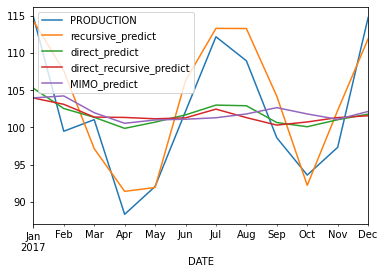

In [47]:
test.plot()

In [48]:
rmse = sqrt(mean_squared_error(test['PRODUCTION'], test['MIMO_predict']))
print(rmse)

8.144372603680475


# Direct MIMO

In [49]:
def generate_data(data, n_input, q_no, n_output):
    X, y = [], []
    for i in range(0,len(data)-(n_input + ((q_no-1)*n_output) + n_output)):
            X.append(data[i:(i+n_input)])
            y.append(data[i+n_input+((q_no-1)*n_output): i+n_input+((q_no-1)*n_output) + n_output])
    return np.array(X), np.array(y)

In [50]:
def model_predict(train_data, n_input, n_features, q_no, n_output):
    
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
    model.add(Dense(n_output))
    model.compile(optimizer='adam', loss='mse')
    
    X, y = generate_data(train_data, n_input, q_no, n_output)
    
    model.fit(X, y, epochs=50, verbose=0)
    
    tX = train_data[-n_input:]
    
    tX = tX.reshape((1, n_input, n_features))
    
    res = model.predict(tX)
    
    return res

In [51]:
n_input = 12
n_features = 1
test_predictions = []

n_output = 3

q = int(len(scaled_test)/n_output)

for i in range(q):
    pred = model_predict(scaled_train,n_input, n_features, i+1, n_output)
    test_predictions.append(pred)

test_predictions

[array([[0.47188914, 0.41930678, 0.3628212 ]], dtype=float32),
 array([[0.33426315, 0.3291704 , 0.33139044]], dtype=float32),
 array([[0.4186204 , 0.38365558, 0.33812553]], dtype=float32),
 array([[0.34168914, 0.34797654, 0.3569049 ]], dtype=float32)]

In [52]:
res = []

for i in test_predictions:
    for j in i:
        for k in j:
            res.append(k)

In [53]:
res = np.array(res)
res = res.reshape((res.shape[0],1))
res.shape

(12, 1)

In [54]:
true_predictions = scaler.inverse_transform(res)

test['Direct_MIMO_predict'] = true_predictions

In [55]:
test

,PRODUCTION,recursive_predict,direct_predict,direct_recursive_predict,MIMO_predict,Direct_MIMO_predict
DATE,,,,,,
2017-01-01,114.8505,114.282237,105.252037,103.944141,103.959137,105.808250
2017-02-01,99.4901,107.601671,102.535667,103.100130,104.223694,103.971581
2017-03-01,101.0396,97.156706,101.360624,101.388220,101.974792,101.998566
2017-04-01,88.3530,91.432015,99.875430,101.338999,100.556419,101.001045
2017-05-01,92.0805,91.947558,100.708512,101.158385,101.001511,100.823158
2017-06-01,102.1532,106.267246,101.682011,101.285310,101.101501,100.900703
2017-07-01,112.1538,113.278170,102.994385,102.451839,101.294472,103.947601
2017-08-01,108.9312,113.257623,102.904441,101.315801,101.807053,102.726303
2017-09-01,98.6154,104.179879,100.652459,100.311220,102.651268,101.135956


<AxesSubplot:xlabel='DATE'>

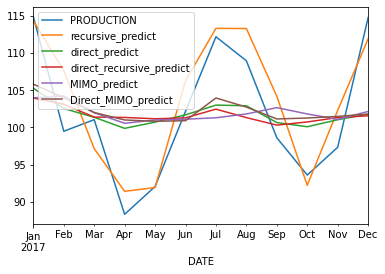

In [56]:
test.plot()

In [57]:
rmse = sqrt(mean_squared_error(test['PRODUCTION'], test['Direct_MIMO_predict']))
print(rmse)

7.6144063948505165


In [58]:
rec_err = abs(test['PRODUCTION'] - test['recursive_predict'])
dir_err = abs(test['PRODUCTION'] - test['direct_predict'])
dir_rec_err = abs(test['PRODUCTION'] - test['direct_recursive_predict'])
mimo_err = abs(test['PRODUCTION'] - test['MIMO_predict'])
dir_mimo_err = abs(test['PRODUCTION'] - test['Direct_MIMO_predict'])

In [59]:
errors = pd.DataFrame({
    'Recursive':rec_err,
    'Direct':dir_err,
    'Direct Recursive':dir_rec_err,
    'MIMO':mimo_err,
    'Direct MIMO':dir_mimo_err
})

In [60]:
errors

,Recursive,Direct,Direct Recursive,MIMO,Direct MIMO
DATE,,,,,
2017-01-01,0.568263,9.598463,10.906359,10.891363,9.042250
2017-02-01,8.111571,3.045567,3.610030,4.733594,4.481481
2017-03-01,3.882894,0.321024,0.348620,0.935192,0.958966
2017-04-01,3.079015,11.522430,12.985999,12.203419,12.648045
2017-05-01,0.132942,8.628012,9.077885,8.921011,8.742658
2017-06-01,4.114046,0.471189,0.867890,1.051699,1.252497
2017-07-01,1.124370,9.159415,9.701961,10.859328,8.206199
2017-08-01,4.326423,6.026759,7.615399,7.124147,6.204897
2017-09-01,5.564479,2.037059,1.695820,4.035868,2.520556


<AxesSubplot:xlabel='DATE'>

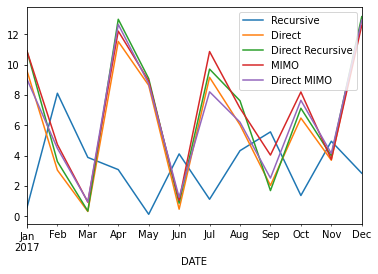

In [61]:
errors.plot()

In [62]:
len(scaled_test)

12